# Model Training

In this notebook the *Dutch Dyslexia Programme (DDP)* and *ePodium* datasets are used to train a deep neural network model.

The model is trained to predict the age and risk of dyslexia from brain signals. This input data consists of the average of multiple epochs of the EEG data, called an *Event Related Potential* (ERP).

+ In section 1. [Prepare Dataset](#1mt) the ePodium and DDP dataset are prepared for input in the deep learning model. The metadata containing the participant info is loaded and the dataset is split into a train, test and validation set. The data is loaded with the *Sequencer* class from TensorFlow, which iterates over the participants in the sets when the data is needed by the model.
+ In section 2. [Deep Learning](#2mt) a deep neural network is trained to predict the age and risk of dyslexia from the ERPs from toddlers. The model types that are used are the *encoder*, *resnet* models. The models, training history, and subset contents are saved in *local_paths.models*.

<br>

---

    It is recommended to run this notebook with CUDA enabled with a dedicated graphics card to speed-up the model training.
    
    In the context of electroencephalography, 'epochs' are EEG intervals in which an event occurs. In this notebook 'epochs' are used in the context of deep learning, in which epochs are iterations over the training dataset.

#### Import Packages

In [1]:
import numpy as np
import os

# Local
import local_paths
from functions import processing, display_helper, data_io
from functions.epodium import Epodium
from functions.ddp import DDP
from functions.sequences import EpodiumSequence, DDPSequence

# Models
from models.dl_4_tsc import encoder_model, fully_convolutional_model, resnet_model
from models.eeg_dl import transformer_model

# Tensorflow dependencies
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy, MeanSquaredError
from keras.metrics import Precision, BinaryAccuracy, Recall
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

<br>
<br>

---

<a id='1mt'></a>
## 1. Prepare Data

#### Choose dataset

This notebook works with both the ePodium and the DDP dataset. Choose which dataset to use by changing the variable: *dataset_name*. 

The *dataset* variable contains information and functions about the specific dataset. The directories to the data and the labels of the selected dataset are loaded.

In [2]:
# Choose between datasets: "epodium" "ddp"
dataset_name = "ddp"

if dataset_name == "epodium":
    dataset = Epodium()    
    epochs_directory = local_paths.ePod_epochs
    event_directory = local_paths.ePod_epochs_events    
    epod_labels = dataset.create_labels(local_paths.ePod_metadata)
    print(f"The available labels are:\n {list(epod_labels.columns)}")

elif dataset_name == "ddp":
    dataset = DDP()
    epochs_directory = local_paths.DDP_epochs
    event_directory = local_paths.DDP_epochs_events    
    directory_age_metadata = os.path.join(local_paths.DDP_metadata, "ages")
    ddp_labels = dataset.create_labels(local_paths.DDP_dataset, directory_age_metadata)
    print(f"The available labels are:\n {list(ddp_labels.columns)}") 

The available labels are:
 ['filename', 'participant', 'age_group', 'age_days']


#### Split valid experiments into train, validation, test set.

1. Get only the valid experiments from each participants. The minimum amount of *standard* and *deviant* trials that need to be in each experiment can be selected.

2. The data is split up into a train, validation, and test set. Each participant can have multiple experiments. The data is split up according to participants, so that no two experiments from the same participant are in multiple sets. The ratio *r* of the subsets is set to 70% test, 15% validation and 15% test set size.

In [3]:
experiment_list = processing.valid_experiments(dataset, event_directory, min_standards=180, min_deviants=80)

# In the DDP dataset some experiments are ignored due to incorrect channels 
if dataset_name == "ddp":
    experiment_list = list(set(experiment_list)-set(dataset.wrong_channels_experiments))
    print(f"{len(dataset.wrong_channels_experiments)} experiments have incorrect channels. "
          f"{len(experiment_list)} experiments remain")

# [train / test / validation] ratio
r = np.array([0.7, 0.15, 0.15])
experiments_train_val, experiments_test = dataset.split_dataset(experiment_list, (r[0]+r[2])/r.sum())
experiments_train, experiments_val = dataset.split_dataset(experiments_train_val, r[0]/(r[0]+r[2]))

print(f"\nThe dataset is split up into {len(experiments_train)} train, "
      f"{len(experiments_test)} test, and {len(experiments_val)} validation experiments")

Analyzed: 1057 bad: 238
819 experiments have enough epochs for analysis.
109 experiments have incorrect channels. 710 experiments remain

The dataset is split up into 487 train, 103 test, and 120 validation experiments


#### Preparing a 'Sequence' as input to the deep learning models.

In this deep learning notebook, the model iterates over a sequence of data. Each data instance in this sequence is only loaded when it is used, and unloaded when the model is done using the data instance. In Tensorflow, such a sequence is implemented with the *Sequence* class:

https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

This notebook uses an extended version of this *Sequence* class for both the ePodium and the DDP dataset: *EpodiumSequence*, *DDPSequence*. When instantiating, some of the variables can be varied without breaking the code. These variables are discussed below.

+ *n_trials_averaged*: The number of trials that are averaged together to get the ERP that is the input to the model. A lower number means more data-points, while a higher number of averaged trials reduces the noise.
+ *gaussian_noise*: Noise can be artificially added to the data to reduce overfitting on the training set. The value of this parameter indicates the variation of the noise that is added to each individual time-step of each channel. 
+ *batch_size*: The number of experiments that are put into a single batch. In deep learning, a model is updated after processing a batch. A lower batch size means more updates, while a larger batch size has the advantage of less variations in the updates.


The *train_sequence* is used for training the model, and the *val_sequence* is used to measure the actual performance of the model.

In [4]:
if dataset_name == "epodium":
    train_sequence = EpodiumSequence(experiments_train, epod_labels, epochs_directory, 
                                     batch_size=4, gaussian_noise=1e-6)
    val_sequence = EpodiumSequence(experiments_val, epod_labels, epochs_directory, 
                                   batch_size=4)
    
if dataset_name == "ddp":
    train_sequence = DDPSequence(experiments_train, ddp_labels, epochs_directory, 
                                 batch_size=8, n_trials_averaged=30, gaussian_noise=1e-6)
    val_sequence = DDPSequence(experiments_val, ddp_labels, epochs_directory, 
                               batch_size=8, n_trials_averaged=30)

<br>
<br>

---


<a id='2mt'></a>
## 2. Deep Learning

Now that the data is set-up, the training model created. The model dimensions are set to the dimensions of the input data and predicted output label(s): 

+ Input x has dimensions: *(batches, timesteps, channels)*
+ Output y has dimensions: *(batches, labels)*

An ERP consists of 2-dimensional input data. One of the dimensions represents the time where *n_timesteps* contains the number of timesteps. The other dimension represents the channels, i.e. the sensor locations on the scalp. The variable *n_channels* signifies the number of channels in the ERP.

The model is trained to predict the output y from an input x. When *y_dimension* is set to 1, the model outputs a single floating point number from the ERP data input. This number can represent a regressive label like *age* and the *risk of dyslexia*.

#### Choose model

Multiple model types can be trained. To pick a model, change the *model_name* variable to contain the desired model. The model options are: **encoder** / **transformer** / **resnet**. Of course, it is also possible to import and use other models.

In [13]:
model_name = "ddp_resnet_age_4"
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Model dimensions
n_channels = 26
n_timesteps = 501
x_dimension = (n_channels, n_timesteps)
y_dimension = 1

if "encoder" in model_name:
    model = encoder_model(x_dimension, y_dimension)
elif "resnet" in model_name:
    model = resnet_model(x_dimension, y_dimension)
else:
    print("No model found. Add a model to the model name.")
#elif "transformer" in model_name:
#     model = transformer_model(x_dimension, y_dimension)
# elif "fcn" in model_name:
#     model = fully_convolutional_model(x_dimension, y_dimension)    

### Train model

The models, training history, and subset contents are saved in the folder *model_name* inside *local_paths.models*. 

Multiple hyperparameters can be adjusted:
+ *epochs*: number of iterations over the dataset
+ *learning_rate*: step size in optimizing the model parameters at each update

*Adam* is used as an optimizer, since this optimizer performs well in a wide variety of cases. The loss of the optimizer is set to *MeanSquaredError*. This is a commonly used loss function in regression analysis where a 2x increase in error corresponds to a 4x increase in the loss.

The model weights are saved when the validation loss is improved with the *ModelCheckpoint* callback. If however the validation loss is not improved, the learning rate is reduced with the *ReduceLROnPlateau* callback. 

In [14]:
# Hyperparameters
epochs = 100
learning_rate = 1e-3

# Paths for saving model data
base_dir = os.path.join(local_paths.models, model_name)
model_dir = os.path.join(base_dir, "model")
subsets_dir = os.path.join(base_dir, "subsets")
path_history = os.path.join(base_dir, "history.npy")
path_weights = os.path.join(base_dir, "weights.h5")

if os.path.exists(model_dir):
    print(f"Model: '{model_name}' already exist. Delete the existing model first or rename this model.")    
else:
    print(f"Create model: {model_name}")
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
    if not os.path.exists(subsets_dir):
        os.mkdir(subsets_dir)

    # Save train / test / validation sets for future testing
    data_io.save_experiment_names(experiments_train, os.path.join(subsets_dir, "train_set.txt"))
    data_io.save_experiment_names(experiments_test, os.path.join(subsets_dir, "test_set.txt"))
    data_io.save_experiment_names(experiments_val, os.path.join(subsets_dir, "validation_set.txt"))

    # Model configurations
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
    checkpointer = ModelCheckpoint(filepath=path_weights, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, factor=0.9, verbose=1)
    
    # Fit model
    history = model.fit(x=train_sequence, validation_data=val_sequence, epochs=epochs, callbacks=[checkpointer, reduce_lr])
    
    # Save model and training history
    model.save(model_dir)
    np.save(path_history, history.history)

Create model: ddp_resnet_age_26ch_500hz_4
Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 699315.8125
Epoch 1: val_loss improved from inf to 710548.25000, saving model to /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_resnet_age_26ch_500hz_4/weights.h5
61/61 [==============================] - 712s 12s/step - loss: 699315.8125 - val_loss: 710548.2500 - lr: 0.0010
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 686065.6875
Epoch 2: val_loss improved from 710548.25000 to 691397.62500, saving model to /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_resnet_age_26ch_500hz_4/weights.h5
61/61 [==============================] - 519s 9s/step - loss: 686065.6875 - val_loss: 691397.6250 - lr: 0.0010
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 669644.3750
Epoch 3: val_loss improved from 691397.62500 to 669352.18750, saving model to /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_resnet_age_

INFO:tensorflow:Assets written to: /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_resnet_age_26ch_500hz_4/model/assets


INFO:tensorflow:Assets written to: /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_resnet_age_26ch_500hz_4/model/assets


#### Show Training History

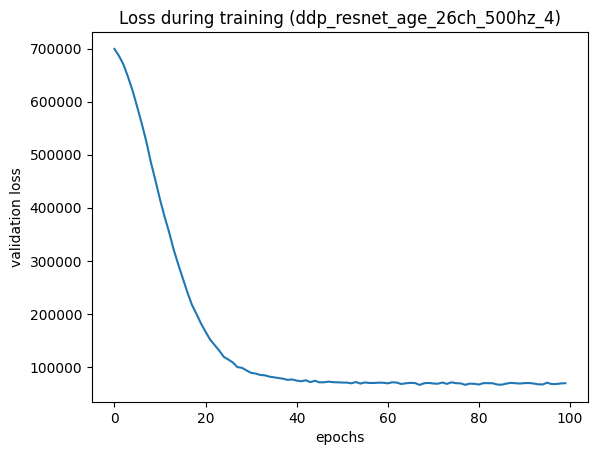

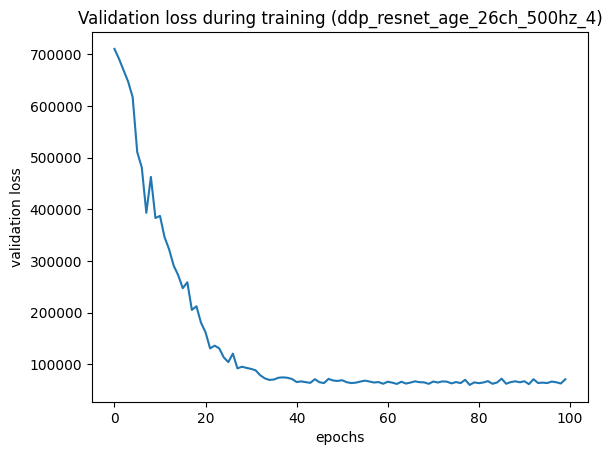

In [15]:
display_helper.show_plot(x=range(len(history.history['loss'])), y=history.history['loss'], xlabel="epochs", ylabel="validation loss", title=f"Loss during training ({model_name})")
display_helper.show_plot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], xlabel="epochs", ylabel="validation loss", title=f"Validation loss during training ({model_name})")